<a href="https://colab.research.google.com/github/Savith-02/notebooks/blob/main/nn_intent_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def read_dataset(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            intent, sentence = line.strip().split(',')
            data.append((intent.strip(), sentence.strip()))
    return data

file_path = "drive/MyDrive/Code/rawData/data_small.txt"
dataset = read_dataset(file_path)[1:]
print(dataset[:10])

[('Greet', 'Hi'), ('Greet', 'Hello'), ('Greet', 'Hey there'), ('Greet', 'Good morning'), ('Greet', 'Howdy'), ('Greet', 'Hi there'), ('Greet', 'Hey'), ('Greet', 'Good afternoon'), ('Greet', 'Hello there'), ('Greet', 'Hi how can I help you?')]


In [2]:
intent_counts = {}
for intent, _ in dataset:
    if intent not in intent_counts:
        intent_counts[intent] = 0
    intent_counts[intent] += 1
print(intent_counts)
print(f"Number of examples in dataset: {len(dataset)}")

{'Greet': 53, 'Farewell': 66, 'Inquiry': 50, 'Feedback': 50, 'Complaint': 38, 'Request': 50, 'Navigation': 58}
Number of examples in dataset: 365


In [3]:
all_sentences = set(sentence for intent, sentence in dataset)
print(f"All unique sentences count: {len(all_sentences)}")

All unique sentences count: 355


In [4]:
# Check for duplicates
# from collections import Counter
# word_counts = Counter(sentence for intent, sentence in dataset)
# word_counts

In [5]:
from itertools import chain

all_words = set(chain(*[sentence.lower().split(" ") for intent, sentence in dataset]))
print(f"All unique sentences count: {len(all_words)}")

All unique sentences count: 723


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
word_to_index = {char: i for i, char in enumerate(all_words)}
print(f"No of words: {len(all_words)}")
print(word_to_index.items())

No of words: 723
dict_items([('guitar?', 0), ('care', 1), ('7', 2), ('pet-friendly', 3), ('really', 4), ('clean', 5), ('recipe.', 6), ('learning', 7), ('chocolate', 8), ('leaky', 9), ('a', 10), ('tight!', 11), ('available?', 12), ('related', 13), ('awesome', 14), ('accuracy', 15), ('day!', 16), ('city?', 17), ('back', 18), ('specific', 19), ('navigate', 20), ('expectations.', 21), ('progress', 22), ('issue?', 23), ('week?', 24), ('thank', 25), ('side', 26), ('issue.', 27), ('problem.', 28), ('mailing', 29), ('way', 30), ('recent', 31), ('translate', 32), ('good', 33), ('events', 34), ('add', 35), ('solution', 36), ('calendar.', 37), ("mother's", 38), ('meet', 39), ('hiking', 40), ('crashing', 41), ('it', 42), ('seamless', 43), ('easy', 44), ('items', 45), ('all!', 46), ('video', 47), ('integration', 48), ('adventure', 49), ('touch', 50), ('everyone', 51), ('list', 52), ('later!', 53), ('excellent.', 54), ('wait', 55), ('contact', 56), ('helpful', 57), ('appreciated.', 58), ('keeps', 59

In [8]:
all_intents = set(intent for intent, _ in dataset[1:])
intent_to_index = {intent: i for i, intent in enumerate(all_intents)}
index_to_intent = {intent: i for i, intent in intent_to_index.items()}

print(f"No of intents {len(all_intents)}")
print(intent_to_index.items())
print(index_to_intent.items())

No of intents 7
dict_items([('Greet', 0), ('Farewell', 1), ('Complaint', 2), ('Inquiry', 3), ('Navigation', 4), ('Request', 5), ('Feedback', 6)])
dict_items([(0, 'Greet'), (1, 'Farewell'), (2, 'Complaint'), (3, 'Inquiry'), (4, 'Navigation'), (5, 'Request'), (6, 'Feedback')])


In [9]:
def sentence_to_tensor(sentence):
    tensor = torch.zeros(len(all_words)).to(device)
    for i, word in enumerate(sentence.lower().split(" ")):
        if word in word_to_index:
          tensor[word_to_index[word]] = 1

    return tensor

In [10]:
# def tensor_to_sentence(tensor, all_words, word_to_index):
#     sentence = []
#     for i in range(len(tensor)):
#         if tensor[i] == 1:
#             word = list(word_to_index.keys())[list(word_to_index.values()).index(i)]
#             sentence.append(word)
#     return " ".join(sentence)

In [11]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, dataset, feature_transform=None, label_transform=None):
        self.data = dataset
        self.feature_transform = feature_transform
        self.label_transform = label_transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return label_transform[sample[0]], feature_transform(sample[1])
            # sample[1] = self.transform(sample[1])


In [12]:
feature_transform = transforms.Compose([
    sentence_to_tensor,
])
label_transform = intent_to_index

In [13]:
from sklearn.model_selection import train_test_split

training_data, test_data = train_test_split(dataset, test_size=0.4, random_state=42)

In [14]:
BATCH_SIZE = 32

train_dataset = CustomDataset(training_data, feature_transform=feature_transform, label_transform=label_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

test_dataset = CustomDataset(test_data, feature_transform=feature_transform, label_transform=label_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
print(f"Number of samples in training dataset: {len(train_dataset)}")
print(f"Number of samples in cv dataset: {len(test_dataset)}")

Number of samples in training dataset: 219
Number of samples in cv dataset: 146


In [15]:
# for batch, (intent, sentence) in enumerate(train_dataloader):
#     if batch == 1:
#       break
#     print(sentence.shape)
#     print(intent.shape)
#     print(intent)
#     print("-----------")

In [16]:
class MyModel(nn.Module):
    def __init__(self, word_count, intent_class_count, hidden_units):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(word_count, hidden_units)
        self.fc2 = nn.Linear(hidden_units, intent_class_count)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
def train_step(model, dataloader, optimizer, loss_fn):

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (intent, sentence) in enumerate(dataloader):

        train_pred_logits = model(sentence)
        loss = loss_fn(train_pred_logits, intent)

        model.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loss = loss_fn(train_pred_logits, intent)

        train_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), dim=1)
        train_acc += (train_pred_class == intent).sum().item() / len(train_pred_class)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [18]:
def test_step(model, dataloader, loss_fn):

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (intent, sentence) in enumerate(dataloader):

        train_pred_logits = model(sentence)
        loss = loss_fn(train_pred_logits, intent)

        train_loss += loss.item()
        loss = loss_fn(train_pred_logits, intent)

        train_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), dim=1)
        train_acc += (train_pred_class == intent).sum().item() / len(train_pred_class)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [19]:
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader, epochs, optimizer, loss_fn):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
          train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer)

          test_loss, test_acc = test_step(model=model,
              dataloader=test_dataloader,
              loss_fn=loss_fn)

          print(
              f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
          )

          results["train_loss"].append(train_loss)
          results["train_acc"].append(train_acc)
          results["test_loss"].append(test_loss)
          results["test_acc"].append(test_acc)

    return results

In [20]:
model = MyModel(len(all_words), len(all_intents), 128)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [21]:
model_0_results = train(model, train_dataloader, test_dataloader, 100, optimizer, loss_fn)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9373 | train_acc: 0.1819 | test_loss: 1.9240 | test_acc: 0.2771
Epoch: 2 | train_loss: 1.8924 | train_acc: 0.5389 | test_loss: 1.9025 | test_acc: 0.5028
Epoch: 3 | train_loss: 1.8468 | train_acc: 0.7556 | test_loss: 1.8753 | test_acc: 0.5750
Epoch: 4 | train_loss: 1.7890 | train_acc: 0.8282 | test_loss: 1.8379 | test_acc: 0.6396
Epoch: 5 | train_loss: 1.7109 | train_acc: 0.8778 | test_loss: 1.7885 | test_acc: 0.6646
Epoch: 6 | train_loss: 1.6119 | train_acc: 0.8957 | test_loss: 1.7270 | test_acc: 0.6646
Epoch: 7 | train_loss: 1.4909 | train_acc: 0.9233 | test_loss: 1.6513 | test_acc: 0.6583
Epoch: 8 | train_loss: 1.3556 | train_acc: 0.9411 | test_loss: 1.5646 | test_acc: 0.6583
Epoch: 9 | train_loss: 1.2022 | train_acc: 0.9501 | test_loss: 1.4698 | test_acc: 0.6833
Epoch: 10 | train_loss: 1.0497 | train_acc: 0.9732 | test_loss: 1.3694 | test_acc: 0.7021
Epoch: 11 | train_loss: 0.8962 | train_acc: 0.9777 | test_loss: 1.2660 | test_acc: 0.7333
Epoch: 12 | train_l

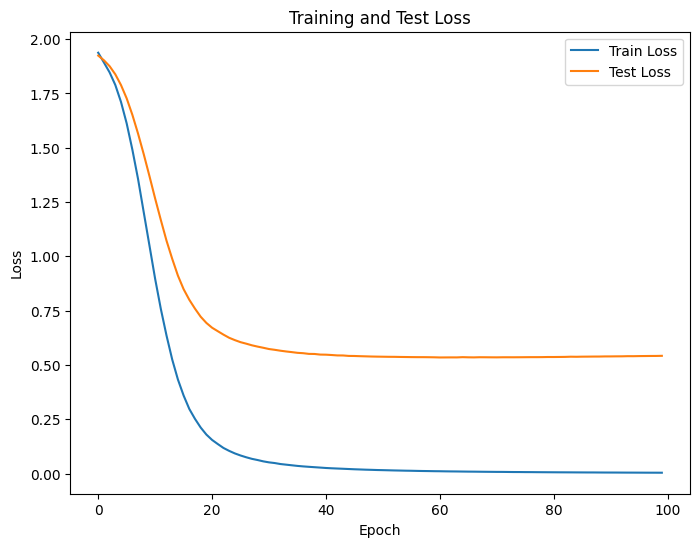

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(model_0_results["train_loss"], label="Train Loss")
ax.plot(model_0_results["test_loss"], label="Test Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training and Test Loss")
ax.legend()
plt.show()

In [23]:
def predict(model, input_data):
    with torch.no_grad():
        pred_logits = model(input_data)
        pred_class = torch.argmax(torch.softmax(pred_logits, dim=0), dim=0)

        return index_to_intent[pred_class.item()]

In [56]:
print(predict(model,  sentence_to_tensor("hI frIend?")))

Greet


In [57]:
from sklearn.metrics import accuracy_score

In [73]:
train_sentences = [[x, y] for y, x in training_data]
train_inputs = list(map(lambda x: sentence_to_tensor(x[0]), train_sentences))
train_targets = list(map(lambda x: intent_to_index[x[1]], train_sentences))
train_predictions = [ int(torch.argmax(torch.softmax(model(input), dim=0), dim=0)) for input in train_inputs]

In [74]:
accuracy_score(train_predictions, train_targets)

1.0

In [75]:
test_sentences = [[x, y] for y, x in test_data]
test_inputs = list(map(lambda x: sentence_to_tensor(x[0]), test_sentences))
test_targets = list(map(lambda x: intent_to_index[x[1]], test_sentences))
test_predictions = [ int(torch.argmax(torch.softmax(model(input), dim=0), dim=0)) for input in test_inputs]

In [76]:
accuracy_score(test_predictions, test_targets)

0.8287671232876712